<a href="https://colab.research.google.com/github/aime-n/ic/blob/main/exemplo_did%C3%A1tico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KG proposto para App Reviews

- app_id <-> snippet (relation='contain_snippet')
- app_id <-> category (relation='is_category')
- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')
- requirement <-> entity_group (relation='contain_tag')


OBS:
- Snippet é uma sentença da review.
- Ainda não temos a categoria, entao ignorar
- entity_group é uma maneira de agrupar os requisitos. Por exemplo, vários requisitos podem ser linkados com o entity_group = 'security'. Ainda não temos essa info, podemos ignorar.



In [1]:
!pip install -q sentence-transformers

     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 3.5 MB 41.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 56.3 MB/s 
     |████████████████████████████████| 6.8 MB 54.1 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 


# KG atual para testes preliminares

- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')

In [2]:
!git clone https://github.com/HaoWeiHe/Knowledge-Graph

Cloning into 'Knowledge-Graph'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 428 (delta 242), reused 97 (delta 31), pack-reused 0
Receiving objects: 100% (428/428), 7.67 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [3]:
mv ./Knowledge-Graph/* .

In [4]:
from knowledgeGraph import get_entity
from knowledgeGraph import get_relation

In [5]:
!pip install -q spacy==3.2

     |████████████████████████████████| 6.0 MB 8.8 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 10.1 MB 53.2 MB/s 
     |████████████████████████████████| 181 kB 51.7 MB/s 
     |████████████████████████████████| 451 kB 55.1 MB/s 
     |████████████████████████████████| 628 kB 45.3 MB/s 


In [6]:
import pandas as pd
ground_truth = pd.read_csv('https://raw.githubusercontent.com/aime-n/ic/main/Ground_truth.csv')
#ground_truth = ground_truth.iloc[0:15]
ground_truth.head()

,App id,Review id,Sentence id,Sentence content,Feature (Positive),Feature (Neutral),Feature (Negative),Feature (All Annotated)
0,com.zentertain.photoeditor,gp:AOqpTOEW40L9WXqCjzq04bqaZImgMdzlczxIF3_ibs8...,1,May be i can check,NaN,NaN,NaN,NaN
1,com.zentertain.photoeditor,gp:AOqpTOF57AQPvmnCiWYurwLY-F2-mej25ON8RAFk-Ls...,1,It make me happy,NaN,NaN,NaN,NaN
2,com.zentertain.photoeditor,gp:AOqpTOHYdmt72q4tSD8TZ8A5fZQqGivlBkIbWuHuJMZ...,1,I have a normal phone and it made 1 of my pics...,NaN,pics,NaN,pics
3,com.zentertain.photoeditor,gp:AOqpTOFYnXMShrDJPS0jpM04pFQxYOJN1LDuX3lSNm0...,1,Love it so much,NaN,NaN,NaN,NaN
4,com.zentertain.photoeditor,gp:AOqpTOF_JO496wnThQ2kcYlPct_g1GhOmQyyVvHp4VV...,1,Cant get to install,NaN,install,NaN,install


In [7]:
import nltk
from nltk.tokenize import sent_tokenize # sentence tokenizer
nltk.download('punkt')
import networkx as nx
from tqdm.notebook import tqdm

KG = nx.Graph()
source = []
target = []
index_l = []
relation_names = []


i=0
for review in tqdm(ground_truth['Sentence content']):
  for sentence in sent_tokenize(review):
    #print('-->',sentence)
    nodes = get_entity(sentence)
    #print('nodes',nodes)
    node1, node2 = nodes[0], nodes[1]

    relation = get_relation(sentence)

    #print(node1,node2,relation)

    if len(node1) > 2 and len(node2) > 2 and len(relation) > 2:
      index_l.append(i)
      KG.add_edge(node1,node2,relation=relation)
      source.append(node1)
      target.append(node2)
      relation_names.append(relation)
  i+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  0%|          | 0/2062 [00:00<?, ?it/s]

In [8]:
# resultado de len(node)>0
print(f'length index_l: {len(index_l)}')
print(f'length KG.edges: {len(KG.edges)}')

length index_l: 475
length KG.edges: 461


In [9]:
df_edges_linguistic = pd.DataFrame({'source': source, 'target': target, 'relation': relation_names})
df_edges_linguistic.head()

,source,target,relation
0,pictures,a few different ones,download
1,you,picture,plenty
2,focus work.plz,samsung galaxy recntly a5,use
3,Its,things,have
4,editing many options,photo editing,recommend


# Adicionando relacoes snippet <=> requirement

In [10]:
def isNaN(num):
    return num != num

for index,row in tqdm(ground_truth.iterrows(),total=len(ground_truth)):
  node1 = row['Sentence content']
  node2 = row['Feature (All Annotated)']
  if isNaN(node2)==False:
    for node in node2.split(';'):
      # print(node)
      KG.add_edge(node1,node,relation='is_requirement')

  0%|          | 0/2062 [00:00<?, ?it/s]

In [11]:
# for i in KG.edges(data=True):
#   print(i)

# Verificando todas as conexoes da estrutura linguistica

In [12]:
# for v in KG.edges(data=True):
#   if v[2]['relation']!='is_requirement':
#     print(v)

# Verificando conexoes entre o KG linguistico e KG requisitos anotados

In [13]:
# for v in KG.edges(data=True):
#   if v[2]['relation']!='is_requirement':
#     print(v)
#     for v2 in KG.neighbors(v[0]):
#       print("\t\t-->",v2)
#     for v2 in KG.neighbors(v[1]):
#       print("\t\t-->",v2)

# OBS: os requisitos extraídos pelo BERT podem ser adicionados na rede da mesma forma dos anotados manualmente...

In [14]:
# def isNaN(num):
#     return num != num

# rebert_requisitos = CSV_REBERT
# for index,row in tqdm(rebert_requisitos.iterrows(),total=len(rebert_requisitos)):
#   node1 = row['Sentence content']
#   node2 = row['Feature (bert)'] # VERIFICAR
#   if isNaN(node2)==False:
#     for node in node2.split(';'):
#       print(node)
#       KG.add_edge(node1,node,relation='is_requirement')

# GCN

In [15]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 10.3 MB/s 
     |████████████████████████████████| 482 kB 63.4 MB/s 
     |████████████████████████████████| 41 kB 668 kB/s 


In [16]:
adj = nx.adjacency_matrix(KG).todense()
g_attr = KG.copy()

c = 0
for node_id, node_data in g_attr.nodes(data = True):
  matrix_row = adj[c]
  node_data["feature"] = matrix_row
  c += 1

In [17]:
list_nodes = list(g_attr.nodes)

matrix_adj = pd.DataFrame(adj)
matrix_adj['index'] = list_nodes
matrix_adj = matrix_adj.set_index('index')

matrix_adj.columns = list_nodes
matrix_adj.head(3)

,pictures,a few different ones,you,picture,focus work.plz,samsung galaxy recntly a5,Its,things,editing many options,photo editing,super i,effects,app,very good features,You,best lot it,photo editing so many tools,First why you,phone,when i,They,really box,few that,5 stars,that,gallery,frames,picture enhanced qualities,Aviary,Sud,un blur photos,always so yea,3 app,nice cn,overall good job,why I,stickers,rubbish apps,Hope,trouble,...,goes offline,How do I search songs now???????,search songs,"Spotify is great, i can listen to all the music I want away from the Internet.",listen to all the music,Loved it so much.I can get all my favorite songs from my favorite artists.,get all my favorite songs,Please fix that or let us downgrade to previous update.,downgrade to previous update,"I can't search and add new songs,fix that!",search new songs,add new songs,Include lyrics option please!,lyrics option,How to search?I don't find it.,"Only problem I have with the app is the inability to download music to an SD card, as I have limited internal storage space.",download music to an SD card,"All you have to do is lock the music from being transferred off the SD card, similar to iTunes.",lock the music from being transferred off the SD card,I can listen to any song I like or want to hear I thank it is great,listen to any song,Love the music,Sometimes the search menu just disappears,search menu,"Would rate it 5 stars but when i use wifi it constantly says I'm not connected to the interent, when i am.",says I'm not connected to the interent,"Please fix this, i hate using my data to download the songs i want.",download the songs,"C'mon everythings on shuffle, random music pops up and ads.",random music pops up,I guess the only free part is the uninstall button.,uninstall button,Even advertisement is not to frequent while enjoying my awesome Playlist.,Playlist,advertisement,This app really awesome i can listen whatever music i want!,listen whatever music i want,I am fully connected to wifi and offline mode is off.,offline mode,Works great for working out and premium is beyond worth it!!!!
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pictures,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
a few different ones,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
you,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
import stellargraph as sg

In [19]:
G = sg.StellarGraph(matrix_adj, df_edges_linguistic[['source', 'target']])

In [20]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2696, Edges: 475

 Node types:
  default: [2696]
    Features: float32 vector, length 2696
    Edge types: default-default->default

 Edge types:
    default-default->default: [475]
        Weights: all 1 (default)
        Features: none


In [21]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [22]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42)

** Sampled 47 positive and 47 negative edges. **


In [23]:
EdgeSplitter.train_test_split?

In [24]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.5 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 42 positive and 42 negative edges. **


In [25]:
epochs = 50

In [26]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [27]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [28]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [29]:
x_inp, x_out = gcn.in_out_tensors()

In [30]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [31]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [32]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 50ms/step - loss: 2.8140 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.8673
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.8140
	binary_accuracy: 0.5000


In [34]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 4.1752 - binary_accuracy: 0.5000 - val_loss: 1.7688 - val_binary_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 1.7773 - binary_accuracy: 0.5000 - val_loss: 1.1825 - val_binary_accuracy: 0.5000 - 104ms/epoch - 104ms/step
Epoch 3/50
1/1 - 0s - loss: 1.1911 - binary_accuracy: 0.5714 - val_loss: 0.7918 - val_binary_accuracy: 0.7128 - 117ms/epoch - 117ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8321 - binary_accuracy: 0.5952 - val_loss: 0.6136 - val_binary_accuracy: 0.7447 - 148ms/epoch - 148ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5759 - binary_accuracy: 0.6786 - val_loss: 0.5122 - val_binary_accuracy: 0.7766 - 166ms/epoch - 166ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4363 - binary_accuracy: 0.7381 - val_loss: 0.4664 - val_binary_accuracy: 0.7660 - 107ms/epoch - 107ms/step
Epoch 7/50
1/1 - 0s - loss: 0.3322 - binary_accuracy: 0.8095 - val_loss: 0.5825 - val_binary_accuracy: 0.7553 - 102ms/epoch - 102ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2864 - binary_acc

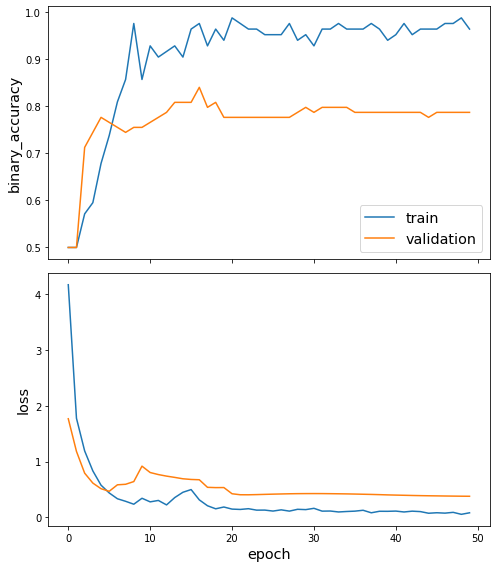

In [35]:
sg.utils.plot_history(history)

In [36]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 71ms/step - loss: 0.3767 - binary_accuracy: 0.7872

Train Set Metrics of the trained model:
	loss: 0.0168
	binary_accuracy: 1.0000

Test Set Metrics of the trained model:
	loss: 0.3767
	binary_accuracy: 0.7872


# Exemplo da Proposta: embutir features de um modelo de linguagem

In [37]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
# adj = nx.adjacency_matrix(KG).todense()
g_attr = KG.copy()

for node_id, node_data in g_attr.nodes(data = True):
  # print('Gerando features para:',node_id)
  feature_linguagem =  model.encode(node_id)
  # print(feature_linguagem)
  node_data["feature"] = feature_linguagem

In [39]:
len(g_attr.edges)

1978

In [40]:
G = sg.StellarGraph.from_networkx(g_attr, node_features="feature")

In [41]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2696, Edges: 1978

 Node types:
  default: [2696]
    Features: float32 vector, length 384
    Edge types: default-default->default

 Edge types:
    default-default->default: [1978]
        Weights: all 1 (default)
        Features: none


In [42]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test_embedding, edge_ids_test_embedding, edge_labels_test_embedding = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42)

** Sampled 197 positive and 197 negative edges. **


In [43]:
print(G_test_embedding.info())

StellarGraph: Undirected multigraph
 Nodes: 2696, Edges: 1781

 Node types:
  default: [2696]
    Features: float32 vector, length 384
    Edge types: default-default->default

 Edge types:
    default-default->default: [1781]
        Weights: all 1 (default)
        Features: none


In [44]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2696, Edges: 428

 Node types:
  default: [2696]
    Features: float32 vector, length 2696
    Edge types: default-default->default

 Edge types:
    default-default->default: [428]
        Weights: all 1 (default)
        Features: none


In [45]:
EdgeSplitter.train_test_split?

In [46]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test_embedding)

# Randomly sample a fraction p=0.5 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 178 positive and 178 negative edges. **


In [47]:
epochs = 50

In [48]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [49]:
test_gen = FullBatchLinkGenerator(G_test_embedding, method="gcn")
test_flow = train_gen.flow(edge_ids_test_embedding, edge_labels_test_embedding)

Using GCN (local pooling) filters...


In [50]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)


In [51]:
x_inp, x_out = gcn.in_out_tensors()

In [52]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [53]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [54]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 45ms/step - loss: 1.0140 - binary_accuracy: 0.6371

Train Set Metrics of the initial (untrained) model:
	loss: 0.8044
	binary_accuracy: 0.7022

Test Set Metrics of the initial (untrained) model:
	loss: 1.0140
	binary_accuracy: 0.6371


In [56]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 2.0166 - binary_accuracy: 0.6545 - val_loss: 0.9853 - val_binary_accuracy: 0.5863 - 846ms/epoch - 846ms/step
Epoch 2/50
1/1 - 0s - loss: 0.9733 - binary_accuracy: 0.6376 - val_loss: 1.1679 - val_binary_accuracy: 0.6218 - 52ms/epoch - 52ms/step
Epoch 3/50
1/1 - 0s - loss: 1.0164 - binary_accuracy: 0.6573 - val_loss: 0.9507 - val_binary_accuracy: 0.5863 - 54ms/epoch - 54ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7417 - binary_accuracy: 0.6882 - val_loss: 0.8028 - val_binary_accuracy: 0.5964 - 51ms/epoch - 51ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8521 - binary_accuracy: 0.7079 - val_loss: 0.7200 - val_binary_accuracy: 0.6218 - 48ms/epoch - 48ms/step
Epoch 6/50
1/1 - 0s - loss: 0.8003 - binary_accuracy: 0.7022 - val_loss: 0.6550 - val_binary_accuracy: 0.6421 - 47ms/epoch - 47ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7599 - binary_accuracy: 0.7275 - val_loss: 0.6596 - val_binary_accuracy: 0.6650 - 48ms/epoch - 48ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6940 - binary_accuracy:

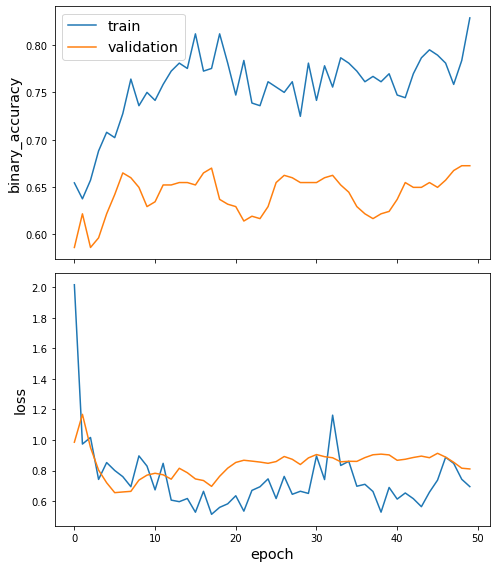

In [57]:
sg.utils.plot_history(history)

In [58]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 42ms/step - loss: 0.8103 - binary_accuracy: 0.6726

Train Set Metrics of the trained model:
	loss: 0.2872
	binary_accuracy: 0.8848

Test Set Metrics of the trained model:
	loss: 0.8103
	binary_accuracy: 0.6726
